
# Runge–Kutta 4 (RK4) for Initial Value Problems
**Author: Hady Hosam**

This notebook features a **fourth‑order explicit Runge–Kutta (RK4)** solver.  
The goal is to implement RK4 from scratch in Python, and verify its **order of accuracy** against an exact solution and compare this to the exact soloution.




## Theory

Considering the initial value problem (IVP)
$$
y'(t)=f(t,y), \qquad y(t_0)=y_0.
$$

RK4 advances from $(t_n,y_n)$ to $(t_{n+1},y_{n+1})$ using four stage slopes:
\begin{align*}
k_1 &= f(t_n,\; y_n), \\
k_2 &= f\!\Big(t_n+\tfrac{h}{2},\; y_n+\tfrac{h}{2}k_1\Big), \\
k_3 &= f\!\Big(t_n+\tfrac{h}{2},\; y_n+\tfrac{h}{2}k_2\Big), \\
k_4 &= f(t_n+h,\; y_n+h\,k_3\Big),
\end{align*}
and the weighted average
$$
y_{n+1}=y_n+\frac{h}{6}\Big(k_1+2k_2+2k_3+k_4\Big), \qquad t_{n+1}=t_n+h.
$$

- **Local truncation error:** $\mathcal O(h^5)$  
- **Global error:** $\mathcal O(h^4)$ (fourth‑order method)

For the linear test equation $y'=\lambda y$, an amplification factor analysis gives the RK4 **stability function**
$$
R(z)=1+z+\tfrac{z^2}{2}+\tfrac{z^3}{6}+\tfrac{z^4}{24}, \qquad z=\lambda h.
$$
The absolute stability region is $\{z\in\mathbb C: |R(z)|<1\}$.



## Implementation

Below, I implement a minimal RK4 stepper and a helper `solve_ivp_fixed` to march with a fixed step.  
I also include a simple Forward Euler stepper to compare accuracy.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

def rk4_step(f, t, y, h):
    """One RK4 step: (t,y) -> (t+h, y_next)."""
    k1 = f(t, y)
    k2 = f(t + 0.5*h, y + 0.5*h*k1)
    k3 = f(t + 0.5*h, y + 0.5*h*k2)
    k4 = f(t + h,     y + h*k3)
    y_next = y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return t + h, y_next

def euler_step(f, t, y, h):
    """One Forward Euler step (for comparison)."""
    return t + h, y + h*f(t, y)

def solve_ivp_fixed(f, t0, y0, h, N, stepper):
    """Fixed-step solver returning arrays of times and states."""
    t = np.empty(N+1, dtype=float)
    y = np.empty(N+1, dtype=float) if np.isscalar(y0) else np.empty((N+1,) + np.shape(y0), dtype=float)
    t[0], y[0] = t0, y0
    tn, yn = t0, y0
    for n in range(N):
        tn, yn = stepper(f, tn, yn, h)
        t[n+1], y[n+1] = tn, yn
    return t, y



## Test problem with exact solution

We test on
$$
y'(t)=-\lambda\,y(t), \qquad y(0)=1, \qquad \text{exact: } y(t)=e^{-\lambda t},
$$
with $\lambda>0$. This lets us quantify the global error easily.


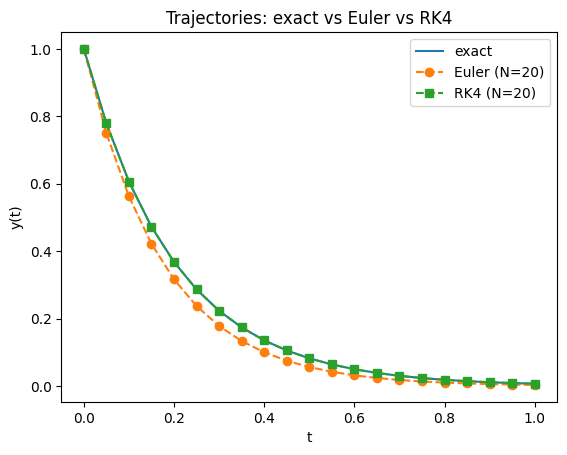

In [2]:

# Parameters
lam = 5.0       # lambda > 0
y0  = 1.0
t0, T = 0.0, 1.0

def f(t, y):
    return -lam*y

def y_exact(t):
    return np.exp(-lam*t)

# Pick a step size and compare Euler vs RK4 trajectories
N  = 20
h  = (T - t0)/N

t_eu, y_eu = solve_ivp_fixed(f, t0, y0, h, N, euler_step)
t_rk, y_rk = solve_ivp_fixed(f, t0, y0, h, N, rk4_step)
y_ex       = y_exact(t_rk)

plt.figure()
plt.plot(t_rk, y_ex, label="exact")
plt.plot(t_eu, y_eu, marker="o", linestyle="--", label="Euler (N=20)")
plt.plot(t_rk, y_rk, marker="s", linestyle="--", label="RK4 (N=20)")
plt.xlabel("t"); plt.ylabel("y(t)")
plt.title("Trajectories: exact vs Euler vs RK4")
plt.legend()
plt.show()



## Convergence Test (error vs. steps)

For a sequence of meshes (increasing $N$, decreasing $h$), we compute the error at $T$:
$$
E(h)=\big|y_{\text{num}}(T)-y_{\text{exact}}(T)\big|.
$$
On a log–log plot, the slope should approach **1** for Euler and **4** for RK4.


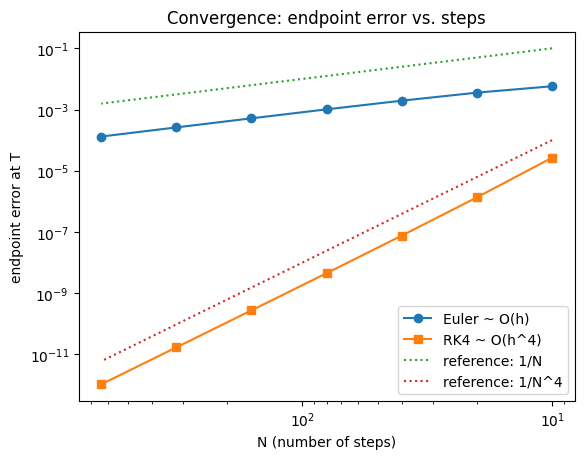

(np.float64(0.9227902230861965), np.float64(4.088279967000119))

In [4]:

def endpoint_error(stepper, N):
    h = (T - t0)/N
    t, y = solve_ivp_fixed(f, t0, y0, h, N, stepper)
    return abs(y[-1] - y_exact(T))

Ns = np.array([10, 20, 40, 80, 160, 320, 640])
err_eu = np.array([endpoint_error(euler_step, int(N)) for N in Ns])
err_rk = np.array([endpoint_error(rk4_step,  int(N)) for N in Ns])

plt.figure()
plt.loglog(Ns, err_eu, marker="o", label="Euler ~ O(h)")
plt.loglog(Ns, err_rk, marker="s", label="RK4 ~ O(h^4)")
plt.loglog(Ns, 1/Ns, linestyle=":", label="reference: 1/N")
plt.loglog(Ns, 1/Ns**4, linestyle=":", label="reference: 1/N^4")
plt.gca().invert_xaxis()
plt.xlabel("N (number of steps)")
plt.ylabel("endpoint error at T")
plt.title("Convergence: endpoint error vs. steps")
plt.legend()
plt.show()

# Report observed slopes via linear regression in log space
p_eu = np.polyfit(np.log(Ns), np.log(err_eu), 1)
p_rk = np.polyfit(np.log(Ns), np.log(err_rk), 1)
obs_order_eu = -p_eu[0]   # because error ~ N^{-p}
obs_order_rk = -p_rk[0]
obs_order_eu, obs_order_rk



## Absolute stability region for RK4

For the test equation $y'=\lambda y$ with $z=\lambda h\in\mathbb C$, RK4 is stable when $|R(z)|<1$, where
$$
R(z)=1+z+\tfrac{z^2}{2}+\tfrac{z^3}{6}+\tfrac{z^4}{24}.
$$
Below is a quick heatmap of $|R(z)|$ over a grid in the complex plane; the **dark region** (values $<1$) is the stability set.


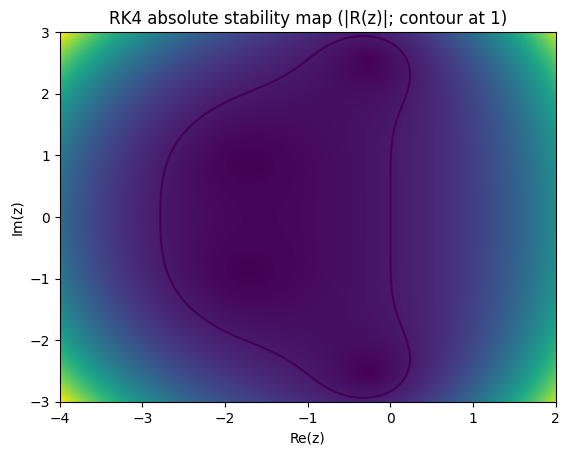

In [5]:

# Build a grid over complex z = x + i y
xr = np.linspace(-4, 2, 400)
yr = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(xr, yr)
Z = X + 1j*Y

R = 1 + Z + Z**2/2 + Z**3/6 + Z**4/24
absR = np.abs(R)

plt.figure()
plt.imshow(absR, extent=[xr.min(), xr.max(), yr.min(), yr.max()], origin="lower", aspect="auto")
plt.contour(X, Y, absR, levels=[1.0])
plt.xlabel("Re(z)"); plt.ylabel("Im(z)")
plt.title("RK4 absolute stability map (|R(z)|; contour at 1)")
plt.show()



## Reflection 

- RK4 achieves **fourth‑order global accuracy** with a simple, explicit stencil.  
- Compared to Euler, the error decreases much faster as the step is refined (slope ≈ 4 on log–log).  
- Stability depends on $z=\lambda h$; even high‑order methods can be unstable if $h$ is too large for a given problem.  

